# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 6</span>


In Statistical Mechanics the one-dimensional (1D) Ising Model is exactly resoluble. The Hamiltonian for a system of N spins with nearest neighbors interaction is given by (in the following I will assume units such that $\mu_B=1$ and $k_B=1$):

$$
H = 
-J\sum_{i=1}^N s_i s_{i+1}
-\frac{h}{2}\sum_{i=1}^N (s_i + s_{i+1}) 
$$

where $\{ s_i \}_{i=1,N}$ are spin variables taking values in $\{-1;1\}$, $J>0$ (ferromagnetic model),and with the assumption $s_{N+1} = s_{1}$.

The partition function for $N$ spins, $Z$, can be exactly computed and it turns out to be:

$$
Z=\sum_{\{ s_i \}} \exp \left( -\beta H\right) = \lambda_1^N + \lambda_2^N
$$

where
$\lambda_{1,2} = 
e^{\beta J} 
\cosh (\beta h) \pm \left[ e^{2\beta J} \cosh^2 (\beta h) - 2\sinh (2\beta J) \right]^{1/2}$, 
and where $\beta=\frac{1}{k_b T} = \frac{1}{T}$.
Once the partition function has been computed, the Helmholtz free energy is readly obtained as $A = -k_B T \ln Z$. All the thermodynamic quantities of interest can be deduced from $A$ or, equivalently, from $Z$.



### Exercise 06.1

Complete the C++ code to simulate 1D Ising model (It is available on the Ariel web site of this Laboratory) with 
- the Metropolis sampling algorithm and
- the Gibbs sampling algorithm

to sample the Boltzmann's weight $p(\{ s_i \}) = \exp(-\beta H)/Z$,
adding also the possibility to restart from a previous spin configuration.

The code already computes the internal energy: $U(N,T) = \langle H \rangle$. Add the calculation of $C(N,T)$, $\chi(N,T)$, $Mthe(N,T,h)$ and compute:
1. $U(N,T) = \langle H \rangle_{h=0}$
2. $C(N,T) = k_B \beta^2 (\langle H^2 \rangle_{h=0}-\langle H \rangle_{h=0}^2)$ 
3. $\chi(N,T) = \beta \langle (\sum_{i=1,N}s_i)^2 \rangle_{h=0}$
4. $M(N,T,h=0.02)= \langle \sum_{i=1,N}s_i \rangle_{h=0.02}$

as a function of $T$ in the range $\left[0.5;2.0\right]$ for a system of $N=50$ spins with $J=1$.

As usual, use data blocking and give an estimate of the statistical uncertainties.

- <span style="color:red">Show pictures of your estimations of $U(N,T)$, $C(N,T)$, $\chi(N,T)$, $M(N,T,h=0.02)$ and their uncertainties</span> obtained with a large number of *MC steps* (e.g. $M\ge 10^5$) compared with the exact curves. In the same picture show your results obtained with both sampling methods, Metropolis and Gibbs.

A Monte Carlo step will consist in trying to flip one time all the spins of the system. Do not forget to equilibrate your simulations and to use blocking average with blocks large enough.

# Equilibration

Initially we study the system equilibration. 
Druing the exercisation we will run differnt simulations with varying temperature $T$. Basically for different temperatures we expect different equilbration times. To avoid complications, we will choose the equilibration time to be same for all the runs at different temperatures. The choice correspond to the worst case scenario, i.e. the equilbration time we find at $T=0.5$, since our initial configuration is a  $T \rightarrow \infty$ configuration. This is inefficent for high temperatures, but for sure we gain in simplicity of the simulation.
We use the energy per particle $U/N$ as observable to control the equilibration time.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os


In [2]:
def load_eq_data(path ,Y_file) : #y is the typo of observable
    x, y = np.loadtxt(path + Y_file , usecols=(0,2) ,  unpack=True)
    return x, y

def plot_eq_data(ax, x, y, observable, samp , T) :
    ax.plot(x, y)#, 
    ax.set_xlabel(f'{samp} step')
   # ax.set_xscale("log")
    ax.set_ylabel(f"{observable}")
    ax.set_title(f"Equilibration for {observable} at T={T}, {samp} sampling")
    ax.grid(True)

In [3]:
Eq_path_M="DATA/Eq_Metropolis/"
Eq_path_G="DATA/Eq_Gibbs/"
paths=[Eq_path_M,Eq_path_G]
methods=["Metropolis", "Gibbs"]

In [4]:
filenames=os.listdir(Eq_path_M)+os.listdir(Eq_path_G)
print(filenames)

['Energy_0.50_M.txt', 'Energy_0.50_G.txt']


In [5]:

#Obs=["C/(N*kb)", "M/N", "U/N", r"$\chi$"]
Obs=["U/N", "U/N"] 
Nobs=len(Obs)

#setting the vectors in which data will be loaded for all observables
step= np.empty(Nobs, dtype=object) #value of the observable per block
obs_vec= np.empty(Nobs, dtype=object)

for i in range(Nobs) :
    print(filenames[i])
    step, obs_vec[i] = load_eq_data(paths[i], filenames[i])

#print(step)
#print(obs_vec[1])

Energy_0.50_M.txt
Energy_0.50_G.txt


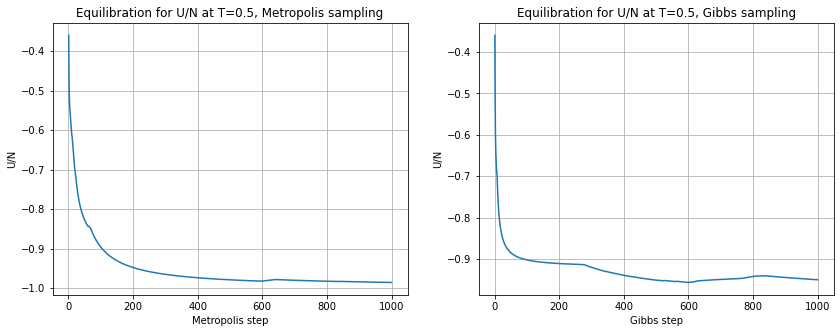

In [6]:
fig, axes = plt.subplots(1, Nobs, figsize=(14, 5))

for ax, i in zip(axes, range(Nobs)) :
        plot_eq_data(ax, step, obs_vec[i], Obs[i], methods[i], 0.5)

We can say that after 500 steps the system is equilibrated, Energy per particle is near -0.9. Which means that most spins are aligned as we should expect is the ground state at low temperatures. 

Now we pass to use the algorithm to get our observables prediction, but before lets make another observation.
We expect the equilibration time to be greater than the autocorellation time scale. we are going to perform data blocking with 20 blocks and 20000 Monte Carlo steps. This way our estimates are obtained with 1000 Monte carlo steps per each block. Hence we are using blocks with a length sufficent to avoid biases introduced by the autocorellation among different states of the Markov chain. In general it is better to do a study of the autocorellation to have a better comprension of the system, in fact it is possible that 1000 Monte Carlo steps are more than what is necessary. We will study the autocorellation for a different problem in the nex lecture.  

# Observables predictions

Now we confront the results of our code with the analytical solutions of the 1D Ising model. We perform both a Metropolis and Gibbs sampling.

- the **Internal Energy** per spin (with $h=0$):

$$
\frac{U(N,T)}{N} = \frac{\langle H \rangle}{N}
= \frac{1}{N} \sum_{\{ s_i \}} H \frac{\exp \left( -\beta H\right)}{Z}
= -\frac{1}{N}\frac{\partial \ln Z}{\partial \beta}
\underset{h=0}= -J \tanh (\beta J) \Biggl( \frac{1 + \tanh^{N-2} (\beta J)}{1+\tanh^N (\beta J)} \Biggl)
$$

In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
####FUNCTIONS
def load_Y_data(path, Y_file) : #y is the typo of observable
    Y, Y_err = np.loadtxt(path + Y_file, usecols = (2,3) ,unpack=True )
    return  Y, Y_err

def plot_Y_data(ax, x, y, err, samp, obs) :
    ax.errorbar(x, y, yerr=err, label=f"{samp}")#, 
    ax.set_xlabel('T')
    ax.set_ylabel(f"{obs}")
    ax.grid(True)
    ax.legend()

In [9]:
my_T=np.arange(0.5, 2.1, 0.1)
print(my_T)
Obs=["U/N", "C/(N*kb)", "M/N",r"$\chi$/N"]

[0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2. ]


In [10]:
path_M="DATA/Metropolis/"
path_G="DATA/Gibbs/"

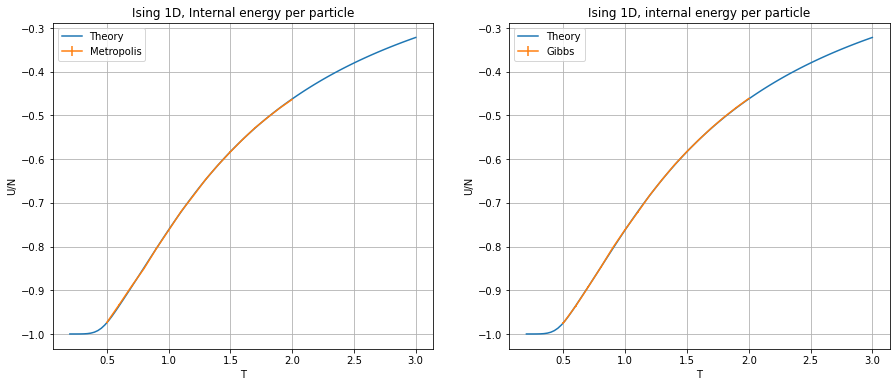

In [11]:
filename_M="Energy_results_M.txt"
filename_G="Energy_results_G.txt"

points=100
T = np.linspace(0.2,3.0,num=points)
beta = 1/T
J = 1.0
Ns = 50
th = np.tanh(J/T)
thN= th**Ns
ch = 1/th
e = -J*( th + ch*thN )/( 1 + thN )


E_M, E_M_err = load_Y_data(path_M, filename_M)
E_G, E_G_err = load_Y_data(path_G, filename_G)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(T, e, label="Theory")
ax1.set_title('Ising 1D, Internal energy per particle')
plot_Y_data(ax1, my_T, E_M, E_M_err, "Metropolis", Obs[0])

ax2.plot(T, e, label="Theory")
ax2.set_title('Ising 1D, internal energy per particle')
plot_Y_data(ax2, my_T, E_G, E_G_err, "Gibbs", Obs[0])


- the **Heat Capacity** (with $h=0$):

$$
C(N,T) = \frac{\partial U(N,T)}{\partial T}
= \frac{\partial \beta}{\partial T}\frac{\partial U}{\partial \beta}
= -k_B\beta^2 \frac{\partial}{\partial \beta} \left[ \sum_{\{ s_i \}} H \frac{\exp \left( -\beta H\right)}{Z} \right] = \\
= -k_B\beta^2 \left[ -\sum_{\{ s_i \}} H^2 \frac{\exp \left( -\beta H\right)}{Z} + \sum_{\{ s_i \}} H \exp \left( -\beta H\right)\frac{\partial Z^{-1}}{\partial \beta} \right] = \\
= k_B\beta^2 \left\{ \sum_{\{ s_i \}} H^2 \frac{\exp \left( -\beta H\right)}{Z} + \left[ \sum_{\{ s_i \}} H \frac{\exp \left( -\beta H\right)}{Z}\right]\frac{1}{Z}\frac{\partial Z}{\partial \beta} \right\} =\\
= k_B\beta^2 \left\{ \sum_{\{ s_i \}} H^2 \frac{\exp \left( -\beta H\right)}{Z} - \left[ \sum_{\{ s_i \}} H \frac{\exp \left( -\beta H\right)}{Z}\right]^2 \right\} =
k_B\beta^2 \left(\langle H^2 \rangle -\langle H \rangle^2 \right)
$$

$$
\frac{C(N,T)}{N} = \frac{1}{N}\frac{\partial U(N,T)}{\partial T} =\\
\underset{h=0}= 
k_B (\beta J)^2 \left\{ 1+\tanh^N (\beta J)+(N-1)\tanh^2 (\beta J)+(N-1)\frac{\tanh^{N-2} (\beta J)}{1+\tanh^N (\beta J)}
- N \left[ \frac{\tanh (\beta J) + \tanh^{N-1} (\beta J)}{1+\tanh^N (\beta J)} \right]^2 \right\}
$$

In [12]:
path="DATA/Metropolis/"

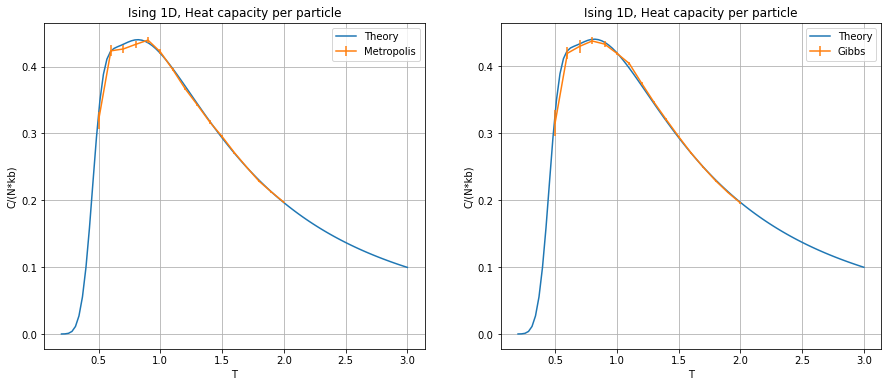

In [13]:
#calcoliamo all'equilibrio le fluttuazioni quadratiche dell'energia e usiamo il teo di dissipazione
filename_M="Heat_results_M.txt"
filename_G="Heat_results_G.txt"

heat=((beta*J)**2)*(((1+thN+(Ns-1)*(th**2)+(Ns-1)*(ch**2)*thN)/(1+thN))-Ns*((th+ch*thN)/(1+thN))**2)

C_M, C_M_err = load_Y_data(path_M, filename_M)
C_G, C_G_err = load_Y_data(path_G, filename_G)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(T, heat, label="Theory")
ax1.set_title('Ising 1D, Heat capacity per particle')
plot_Y_data(ax1, my_T, C_M, C_M_err, "Metropolis", Obs[1])

ax2.plot(T, heat, label="Theory")
ax2.set_title('Ising 1D, Heat capacity per particle')
plot_Y_data(ax2, my_T, C_G, C_G_err, "Gibbs", Obs[1])



- The **magnetization** (with $h \not= 0$):

Note that with $h=0$ the magnetization $M(N,T,h=0)=\langle \sum_{i=1,N}s_i \rangle =0$ because in 1D we cannot have a (ferromagnetic) phase transition in absence of an external magnetic field.

$$
M(N,T,h) = -\frac{\partial A}{\partial h} = k_B T \frac{\partial \ln Z}{\partial h} =
\frac{1}{\beta} \frac{1}{Z}\frac{\partial}{\partial h}\sum_{\{ s_i \}} \exp \left( -\beta H\right) = \sum_{\{ s_i \}} \left[ \sum_{i=1,N}s_i\right] \frac{\exp \left( -\beta H\right)}{Z} = \left\langle \sum_{i=1,N}s_i \right\rangle
$$

The exact formula from $M(N,T,h) = k_B T \dfrac{\partial \ln Z}{\partial h}$ is:
$$
\frac{M(N,T,h)}{N}=\frac{e^{\beta J}\; \sinh(\beta h)}{Z} \; \Bigl[\lambda_1^{N-1}\cdot \Bigl(1+\frac{e^{\beta J}\; \cosh(\beta h)}{\sqrt{e^{2\beta J} \cosh^2 (\beta h) - 2\sinh (2\beta J)}}\Bigr) + \lambda_2^{N-1}\cdot \Bigl(1-\frac{e^{\beta J}\; \cosh(\beta h)}{\sqrt{e^{2\beta J} \cosh^2 (\beta h) - 2\sinh (2\beta J)}}\Bigr)\Bigr]
$$

In [14]:
filename_M="Mag_results_M.txt"
filename_G="Mag_results_G.txt"

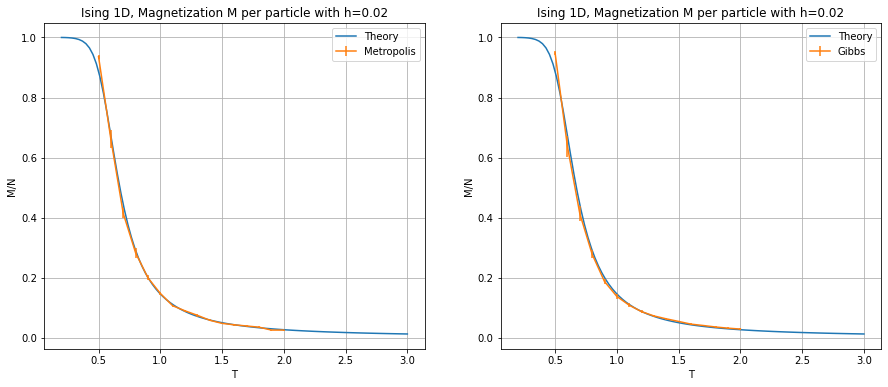

In [15]:

h=0.02 #external field
b = 1/T

l1 = np.exp(b*J)*np.cosh(b*h)+np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
l2 = np.exp(b*J)*np.cosh(b*h)-np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
Z = l1**Ns + l2**Ns
M = (np.exp(b*J)*np.sinh(b*h)*((l1**(Ns-1))*(1+np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))) 
        + (l2**(Ns-1))*(1-np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J)))))/(Z)


Mag_M, Mag_M_err = load_Y_data(path_M, filename_M)
Mag_G, Mag_G_err = load_Y_data(path_G, filename_G)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(T, M, label="Theory")
ax1.set_title('Ising 1D, Magnetization M per particle with h=0.02')
plot_Y_data(ax1, my_T, Mag_M, Mag_M_err, "Metropolis", Obs[2])

ax2.plot(T, M, label="Theory")
ax2.set_title('Ising 1D, Magnetization M per particle with h=0.02')
plot_Y_data(ax2, my_T, Mag_G, Mag_G_err, "Gibbs", Obs[2])



- The **magnetic susceptibility** (with $h=0$):

$$
\chi(N,T) = \frac{\partial M}{\partial h} = 
\frac{\partial}{\partial h}\sum_{\{ s_i \}} \left[ \sum_{i=1,N}s_i\right] \frac{\exp \left( -\beta H\right)}{Z} =\\
= \beta\sum_{\{ s_i \}} \left[ \sum_{i=1,N}s_i\right]^2 \frac{\exp \left( -\beta H\right)}{Z}
-\sum_{\{ s_i \}} \left[ \sum_{i=1,N}s_i\right] \frac{\exp \left( -\beta H\right)}{Z}
\frac{1}{Z}\frac{\partial Z}{\partial h} = 
\beta \left[ \left\langle \left( \sum_{i=1,N}s_i \right)^2 \right\rangle - \left\langle \sum_{i=1,N}s_i \right\rangle^2 \right] = \\
\underset{h=0}= \beta \left[ \left\langle \left( \sum_{i=1,N}s_i \right)^2 \right\rangle \right] = \beta e^{2\beta J} \Biggl( \frac{1-\tanh^N (\beta J)}{1+\tanh^N (\beta J)} \Biggl)
$$

In [16]:
filename_M="Chi_results_M.txt"
filename_G="Chi_results_G.txt"

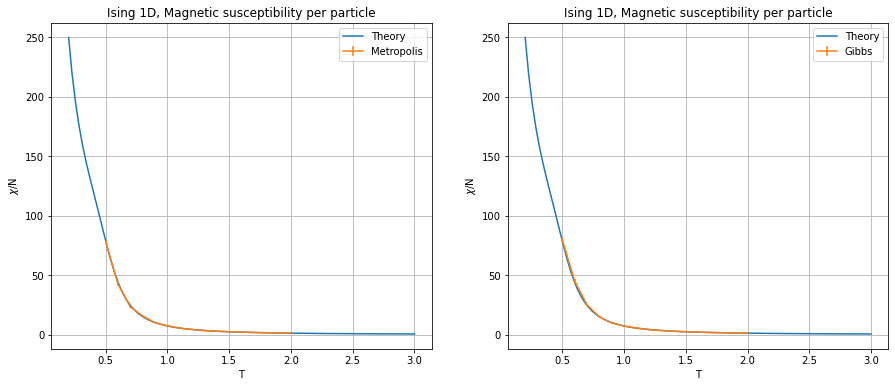

In [17]:

X = beta*np.exp(2*beta*J)*(1-thN)/(1+thN)

X_M, X_M_err = load_Y_data(path_M, filename_M)
X_G, X_G_err = load_Y_data(path_G, filename_G)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(T, X, label="Theory")
ax1.set_title('Ising 1D, Magnetic susceptibility per particle')
plot_Y_data(ax1, my_T, X_M, X_M_err, "Metropolis", Obs[3])

ax2.plot(T, X, label="Theory")
ax2.set_title('Ising 1D, Magnetic susceptibility per particle')
plot_Y_data(ax2, my_T, X_G, X_G_err, "Gibbs", Obs[3])


All the observables predictions are compatible with the numerical solutions, for both sampling methods.